In [24]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
from tqdm import tqdm

import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR import NPI, setup, file_paths, parameters
from SEIR.utils import config
import pathlib
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import subprocess
import Outcomes.outcomes as outcomes
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

## Taken from s3 pull

In [25]:
outdir = ''
mask10 = '00000001'   # So we just do
all_runs = {'model_output':{
                'bucket':  's3://idd-inference-runs/USA-20210513T031236/model_output/',
                'config':  '../COVID19_USA/config_fchub_rd6_delta_high.yml',
                'geodata': '../COVID19_USA/'},
#            'R5_lowVac_lowNPI_npiredux':{
#                'bucket':  's3://idd-inference-runs/USA-20210513T162809/model_output/',
#                'config':  '../COVID19_USA/config_smh_R5_lowVac_lowNPI_npiredux.yml',
#                'geodata': '../COVID19_USA/'}
}

In [ ]:
for run_name, run_spec in all_runs.items():
    print(f'pulling {run_name}')
    command = f"""aws s3 sync {run_spec['bucket']} {outdir}{run_name}/ --exclude "*" --include "*/global/final/{mask10}*" """
    print(f'{command}')
    result = subprocess.run(command, stdout=subprocess.PIPE, shell=True)

pulling model_output
aws s3 sync s3://idd-inference-runs/USA-20210513T031236/model_output/ model_output/ --exclude "*" --include "*/global/final/00000001*" 


In [8]:
outdir

's3pull/'

In [43]:
betas = {}
r0s = {}
diffIs = {}
incidProbs = {}
for run_name, run_spec in all_runs.items():
    print(f'doing {run_name}')
    config.clear()
    config.read(user=False)
    config.set_file(run_spec['config'])
    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(run_spec['geodata'] + spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True
    npi_df = []

    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        parameters_config=config["seir"]["parameters"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix
    )

    folder = [str(x) for x in Path(f'{outdir}{run_name}/snpi/').glob('**') if not x.is_file()]
    folder.reverse()
    folder = [x for x in folder if 'chimeric' not in x]

    folder = folder[0]
    
    betas[run_name] = []
    r0s[run_name] = []
    diffIs[run_name] = []
    
    maxfiles = 20

    print(f'Exploring {str(folder)[:]} ... ', end = '')
    files_loaded = 0
    for snpi_fn in Path(str(folder)).rglob('*.parquet'):
        snpi_fn = str(snpi_fn)
        if ('chimeric' not in snpi_fn and files_loaded < maxfiles):
            print(snpi_fn)
            slot = int(snpi_fn.split('/')[-1].split('.')[0])
            sim = snpi_fn.split('/')[-1].split('.')[1]
            #hpar =  pq.read_table(hpar_fn).to_pandas()
            #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
            #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
            #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
            seirf = pq.read_table(snpi_fn.replace('snpi', 'seir')).to_pandas()
            diffIs[run_name].append(seirf)

            snpi = pq.read_table(snpi_fn).to_pandas()
            npi = NPI.NPIBase.execute(
                npi_config=s.npi_config,
                global_config=config,
                geoids=s.spatset.nodenames,
                loaded_df = snpi)
            p_draw = s.parameters.parameters_load(snpi_fn.replace('snpi', 'spar')[:-8],  
                s.n_days,
                s.nnodes,
                'parquet'
            )

            parameters = s.parameters.parameters_reduce(p_draw, npi)
            betas[run_name].append(npi.getReduction('r0').T)#['06000']#.mean(axis=1) #
            r0s[run_name].append(parameters[1])
            
            #reduc = snpi.set_index('npi_name').T
            #reduc.columns = [n.lower() for n in reduc.columns]
            #reduc = reduc.loc[['reduction','geoid']].T.reset_index()
            #reduc['reduction'] = pd.to_numeric(reduc['reduction'])
            #npi_df = npi_df.append(reduc)

            files_loaded += 1

    print(files_loaded, 'files read')

doing model_output
Exploring model_output/snpi/USA/inference/med/2021.07.05.13:06:58.UTC/global/intermediate ... model_output/snpi/USA/inference/med/2021.07.05.13:06:58.UTC/global/intermediate/000000001.000000001.000000001.2021.07.05.13:06:58.UTC.snpi.parquet
model_output/snpi/USA/inference/med/2021.07.05.13:06:58.UTC/global/intermediate/000000001.000000001.000000002.2021.07.05.13:06:58.UTC.snpi.parquet


OSError: Passed non-file path: model_output/seir/USA/inference/med/2021.07.05.13:06:58.UTC/global/intermediate/000000001.000000001.000000002.2021.07.05.13:06:58.UTC.seir.parquet

In [76]:
print(s.parameters.pnames2pindex)

{'alpha': 0,
 'sigma': 1,
 'gamma': 2,
 'R0s': 3,
 'susceptibility_reduction 0': 4,
 'transmissibility_reduction 0': 5,
 'susceptibility_reduction 1': 6,
 'transmissibility_reduction 1': 7,
 'susceptibility_reduction 2': 8,
 'transmissibility_reduction 2': 9,
 'transition_rate 0': 10,
 'transition_rate 1': 11}

In [79]:
print(s.parameters.pnames)

['alpha', 'sigma', 'gamma', 'R0s', 'susceptibility_reduction 0', 'transmissibility_reduction 0', 'susceptibility_reduction 1', 'transmissibility_reduction 1', 'susceptibility_reduction 2', 'transmissibility_reduction 2', 'transition_rate 0', 'transition_rate 1']


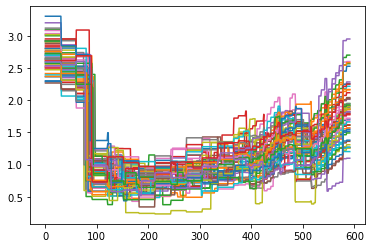

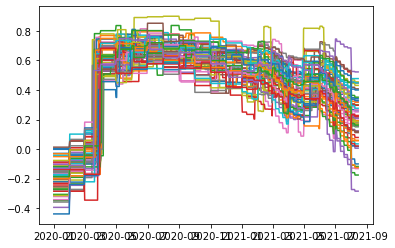

In [5]:
import SEIR
idx = 3
pn = 'r0'
ptest=SEIR.setup._parameter_reduce(parameter=p_draw[idx],
                             modification=npi.getReduction(pn.lower()))
plt.plot(ptest);
plt.figure()
plt.plot(npi.getReduction(pn.lower()).T);

In [38]:
s.compartments.get_transition_array(parameters, s.parameters.pnames)


(array([[[  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ],
         [  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ],
         [  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ],
         ...,
         [  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ],
         [  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ],
         [  1.        ,   1.        ,   1.        , ...,   1.        ,
            1.        ,   1.        ]],
 
        [[  0.99      ,   0.99      ,   0.99      , ...,   0.99      ,
            0.99      ,   0.99      ],
         [  0.99      ,   0.99      ,   0.99      , ...,   0.99      ,
            0.99      ,   0.99      ],
         [  0.99      ,   0.99      ,   0.99      , ...,   0.99      ,
            0.99      ,   0.99  

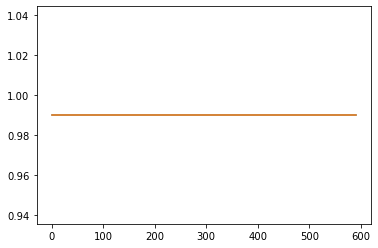

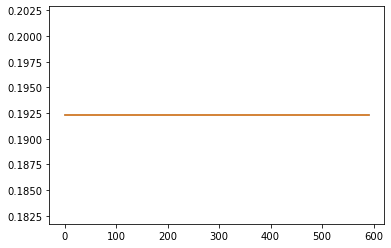

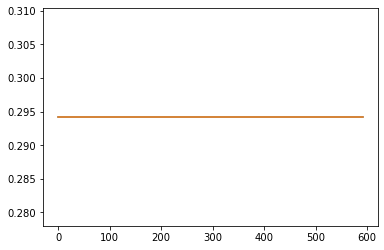

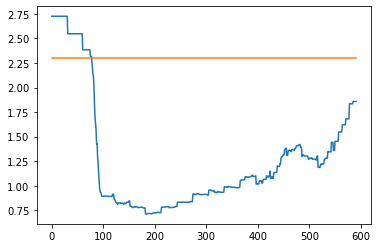

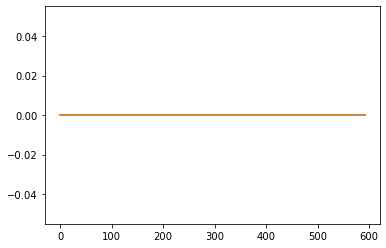

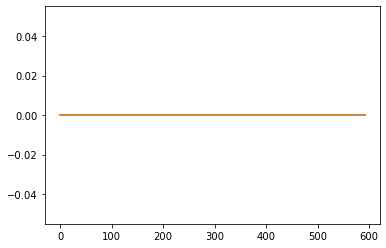

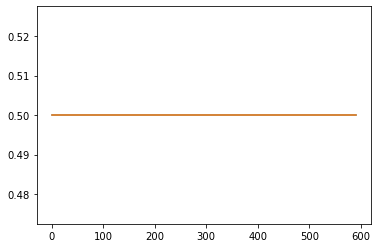

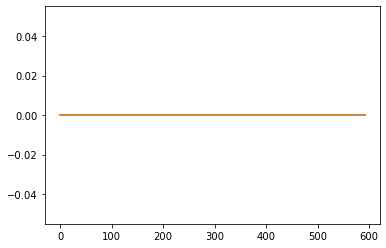

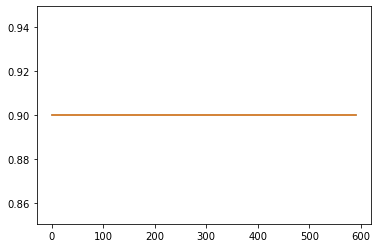

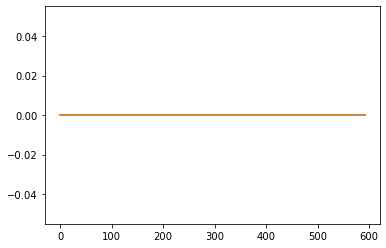

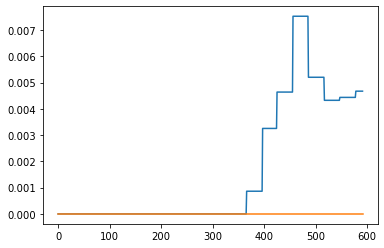

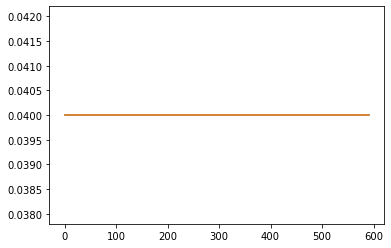

In [6]:
for i in range(parameters.shape[0]):
    plt.figure()
    plt.plot(parameters[i].mean(axis=1))
    plt.plot(p_draw[i].mean(axis=1))

In [34]:
ts = diffIs[name][0]
cp = 'S'
print(ts.columns)
ts

Index(['value_type', 'mc_infection_stage', 'mc_vaccination_stage', 'mc_name',
       '69000', '78000', '66000', '56000', '50000', '11000', '02000', '38000',
       '46000', '10000', '30000', '44000', '23000', '33000', '15000', '16000',
       '54000', '31000', '35000', '20000', '32000', '28000', '05000', '49000',
       '19000', '72000', '09000', '40000', '41000', '21000', '22000', '01000',
       '45000', '27000', '08000', '55000', '24000', '29000', '18000', '47000',
       '25000', '04000', '53000', '51000', '34000', '26000', '37000', '13000',
       '39000', '17000', '42000', '36000', '12000', '48000', '06000', 'date'],
      dtype='object')


,value_type,mc_infection_stage,mc_vaccination_stage,mc_name,69000,78000,66000,56000,50000,11000,...,37000,13000,39000,17000,42000,36000,12000,48000,06000,date
0,incidence,S,unvaccinated,S_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
1,incidence,S,unvaccinated,S_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-02
2,incidence,S,unvaccinated,S_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-03
3,incidence,S,unvaccinated,S_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-04
4,incidence,S,unvaccinated,S_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7099,prevalence,R,unvaccinated,R_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-10
7100,prevalence,R,unvaccinated,R_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-11
7101,prevalence,R,unvaccinated,R_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-12
7102,prevalence,R,unvaccinated,R_unvaccinated,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-13


KeyError: 'first_dose'

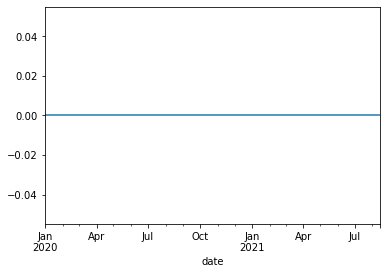

<Figure size 432x288 with 0 Axes>

In [35]:
ts = diffIs[name][0]
cp = 'R'
ts = ts[(ts['mc_infection_stage']==cp) & (ts['value_type']=='prevalence')]
ts = ts.drop(['value_type', 'mc_infection_stage', 'mc_name'],axis=1)
ts = ts.set_index('date').pivot(columns = 'mc_vaccination_stage').sum(axis=1,level=1)
ts['unvaccinated'].plot()
plt.figure()
ts['first_dose'].plot()

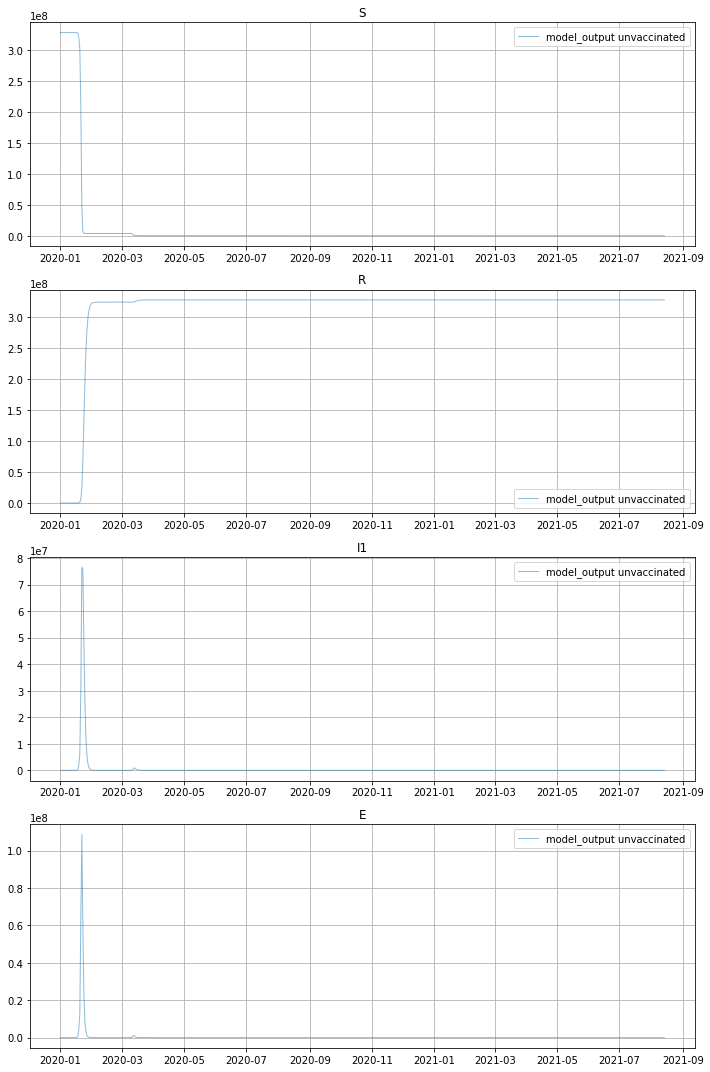

In [44]:
fig, axes = plt.subplots(4,1, figsize = (10,15))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
linestyle = ['-', ':', '-.']

comptoplot = ['S','R', 'I1', 'E']

for k, cp in enumerate(comptoplot):
    ax = axes[k]
    i = 0
    for name, dc in all_runs.items():
        label = name
        ts_all = []
        for sim, ts in enumerate(diffIs[name]):
            ts = ts[(ts['mc_infection_stage']==cp) & (ts['value_type']=='prevalence')]
            ts = ts.drop(['value_type', 'mc_infection_stage', 'mc_name'],axis=1)
            ts = ts.set_index('date').pivot(columns = 'mc_vaccination_stage').sum(axis=1,level=1)
            ts_all.append(ts)
            for idx, cn in enumerate(ts.columns):
                ax.plot(ts[cn], colors[idx],  ls=linestyle[int(idx)], alpha=0.5, label = label + f' {cn}', lw=1,) # lw = int(sim),
                pass
            label = '_'
        #ax.plot(pd.concat(ts_all, axis=1).loc[:,0.0].mean(axis=1),colors[i], ls='--', alpha=0.7, label = label + f' mean', lw=3,) # lw = int(sim),


           # ax.set_yscale('log')
        i+=1

    ax.legend()
    ax.grid()
    ax.set_title(cp)
    #ax.set_xlim('2021-05-01','2021-11-01')
fig.tight_layout()
fig.set_facecolor('white')

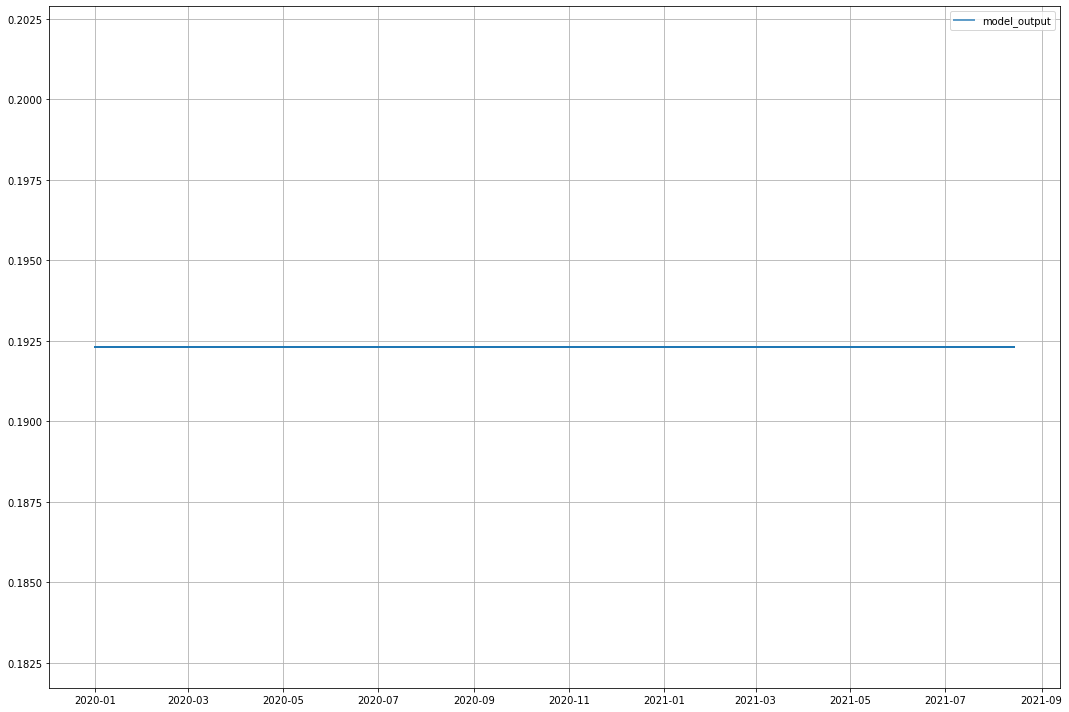

In [49]:
fig, axes = plt.subplots(1,1, figsize = (15,10))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
ax = axes
i = 0
for run_name, run_spec in all_runs.items():
    label = run_name
    for sim, ts in enumerate(r0s[run_name]):
        a = pd.DataFrame(index = pd.date_range(s.ti, s.tf), data = ts.mean(axis=1))
        ax.plot(a, colors[i],  ls='-', alpha=0.7, label = label, lw=2) # lw = int(sim),
        label = '_'
       
       # ax.set_yscale('log')
    i+=1
fig.tight_layout()
fig.set_facecolor('white')
ax.legend()
ax.grid()
#ax.set_xlim('2021-05-01','2021-11-01')
#ax.set_ylim(0.4,0.6)

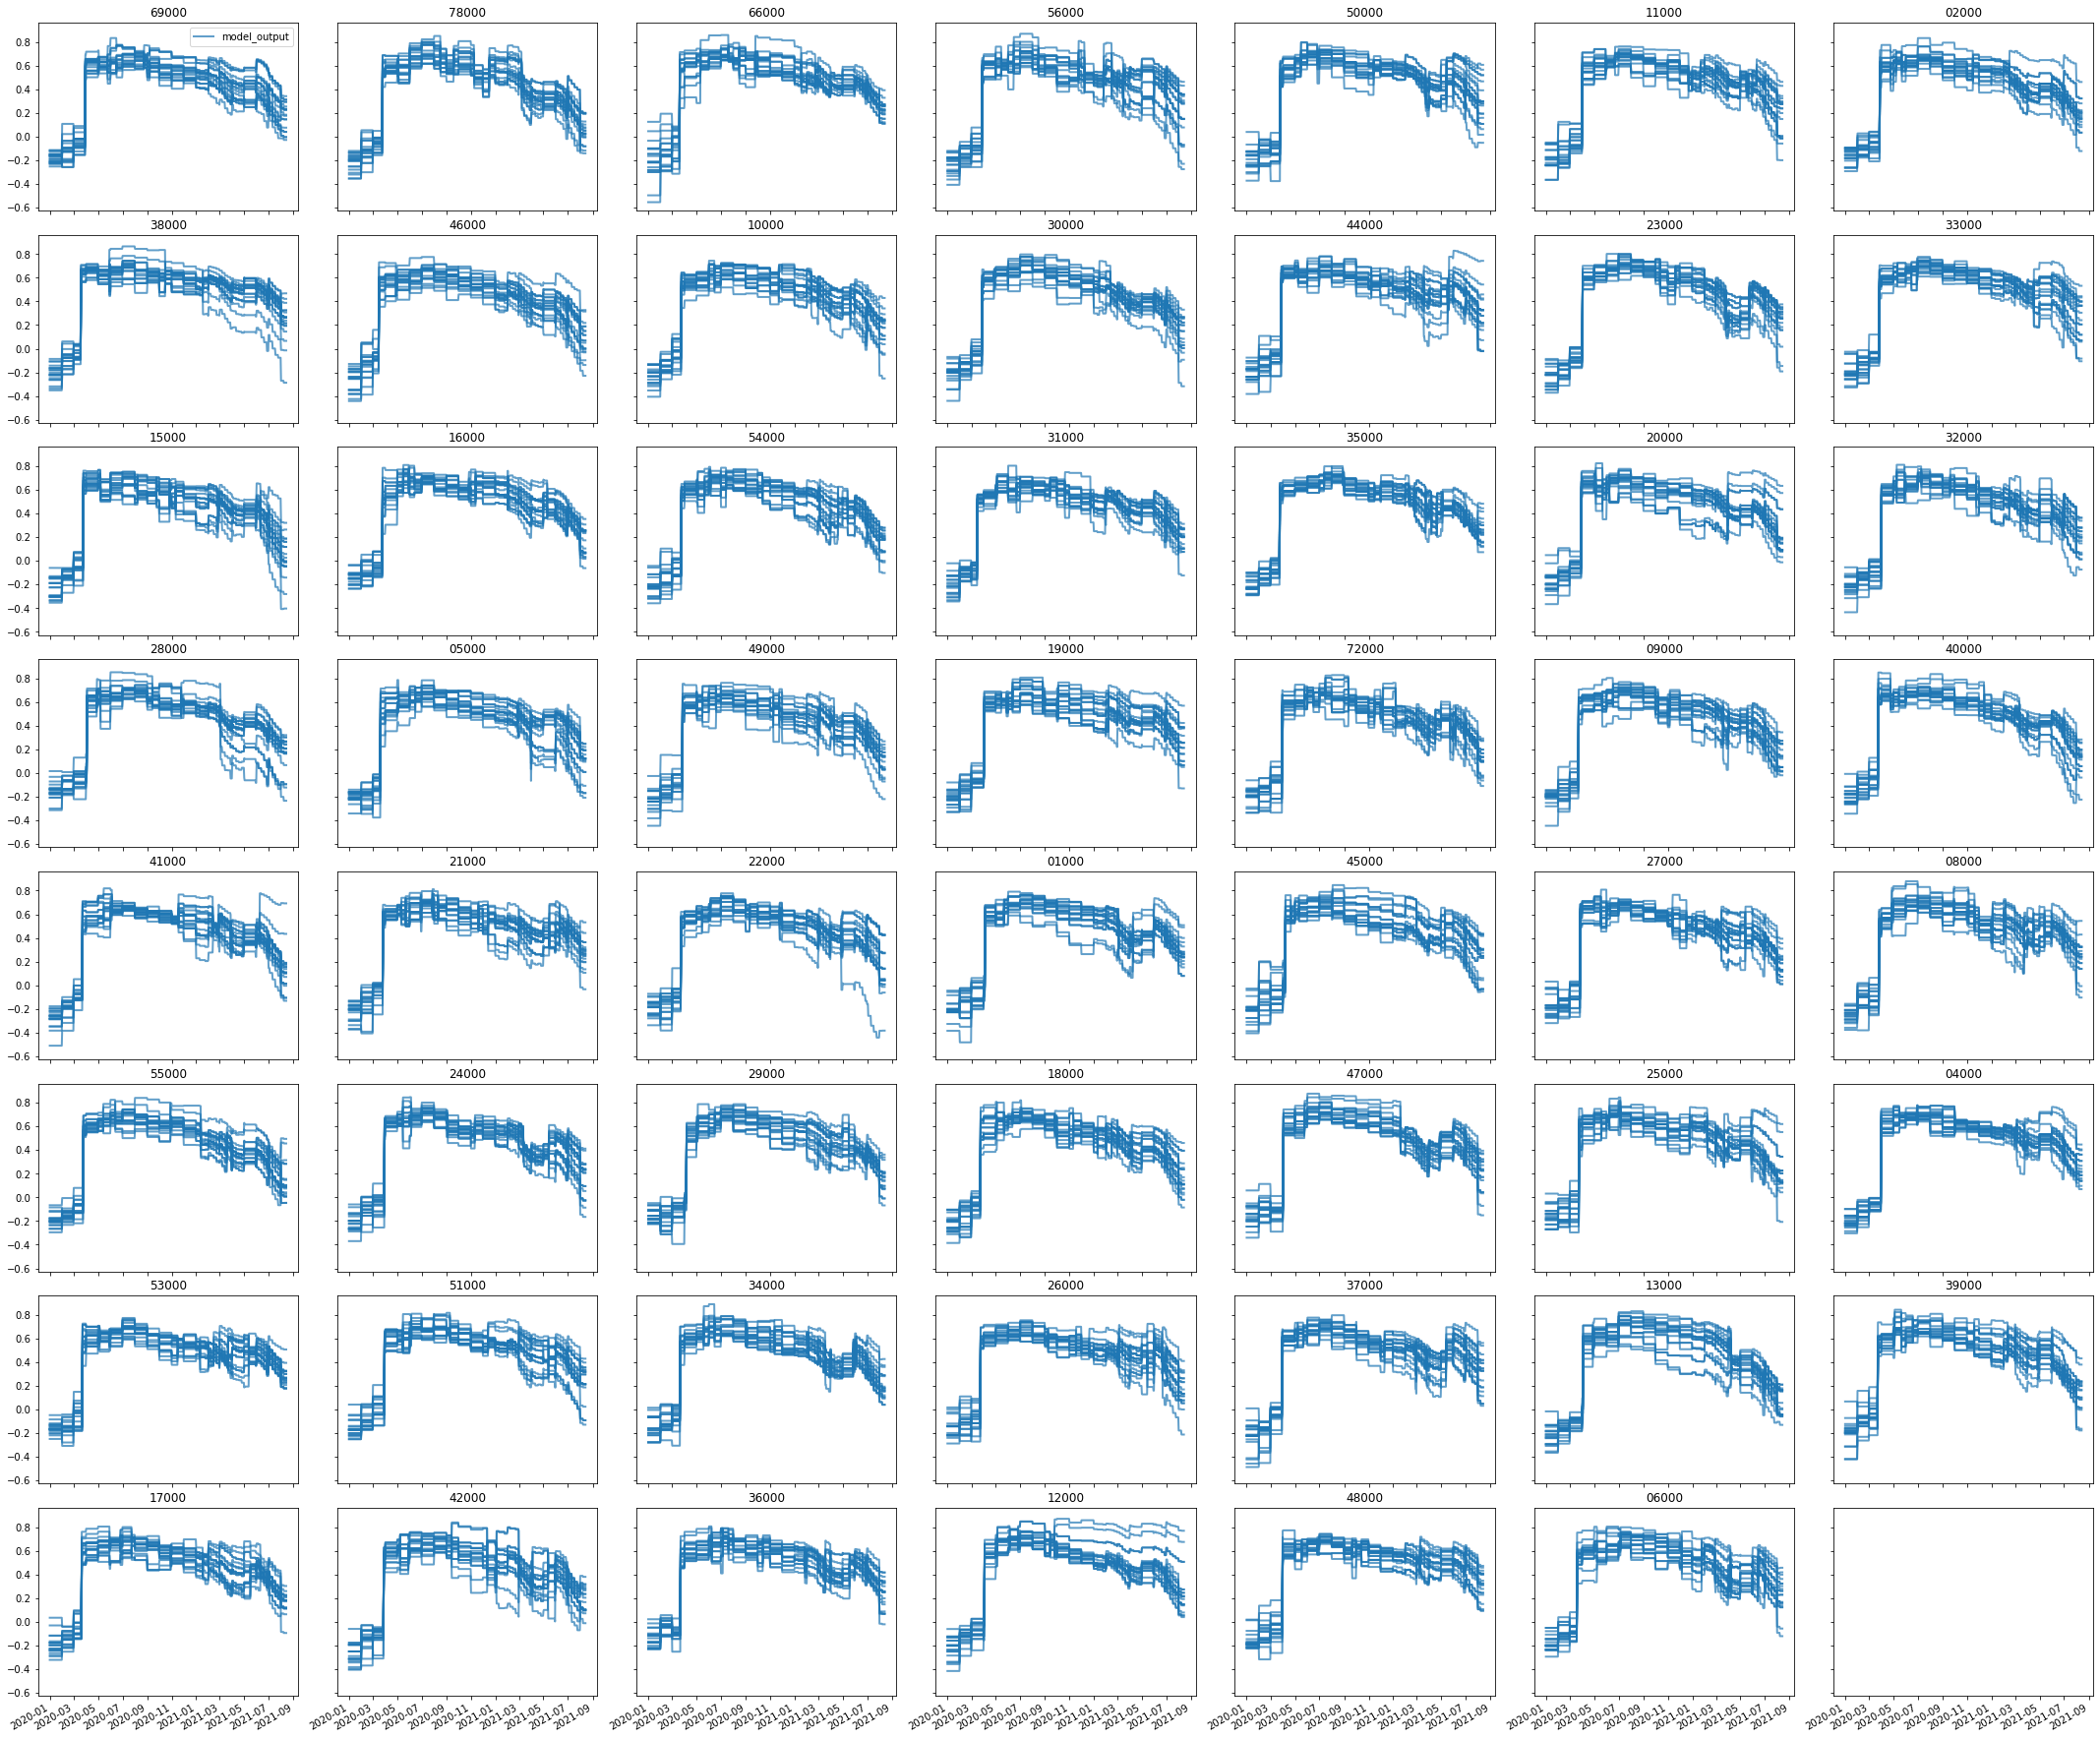

In [51]:
fig, ax = plt.subplots(8,7, figsize = (30,30), sharex = True, sharey=True)
fig.set_facecolor('white')
#colors = ['r', 'b']
j = 0

for name, dc in all_runs.items():
    k=0
    for sim, ts in enumerate(betas[name]):
        for i, nd in enumerate(s.spatset.nodenames):
            if  k == 0:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2, label = name)
                k = 1
            else:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2)
            ax.flat[i].set_title(nd)
            ax.flat[i].grid()
                
    j += 1
ax.flat[0].legend()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('seir_npi.pdf')

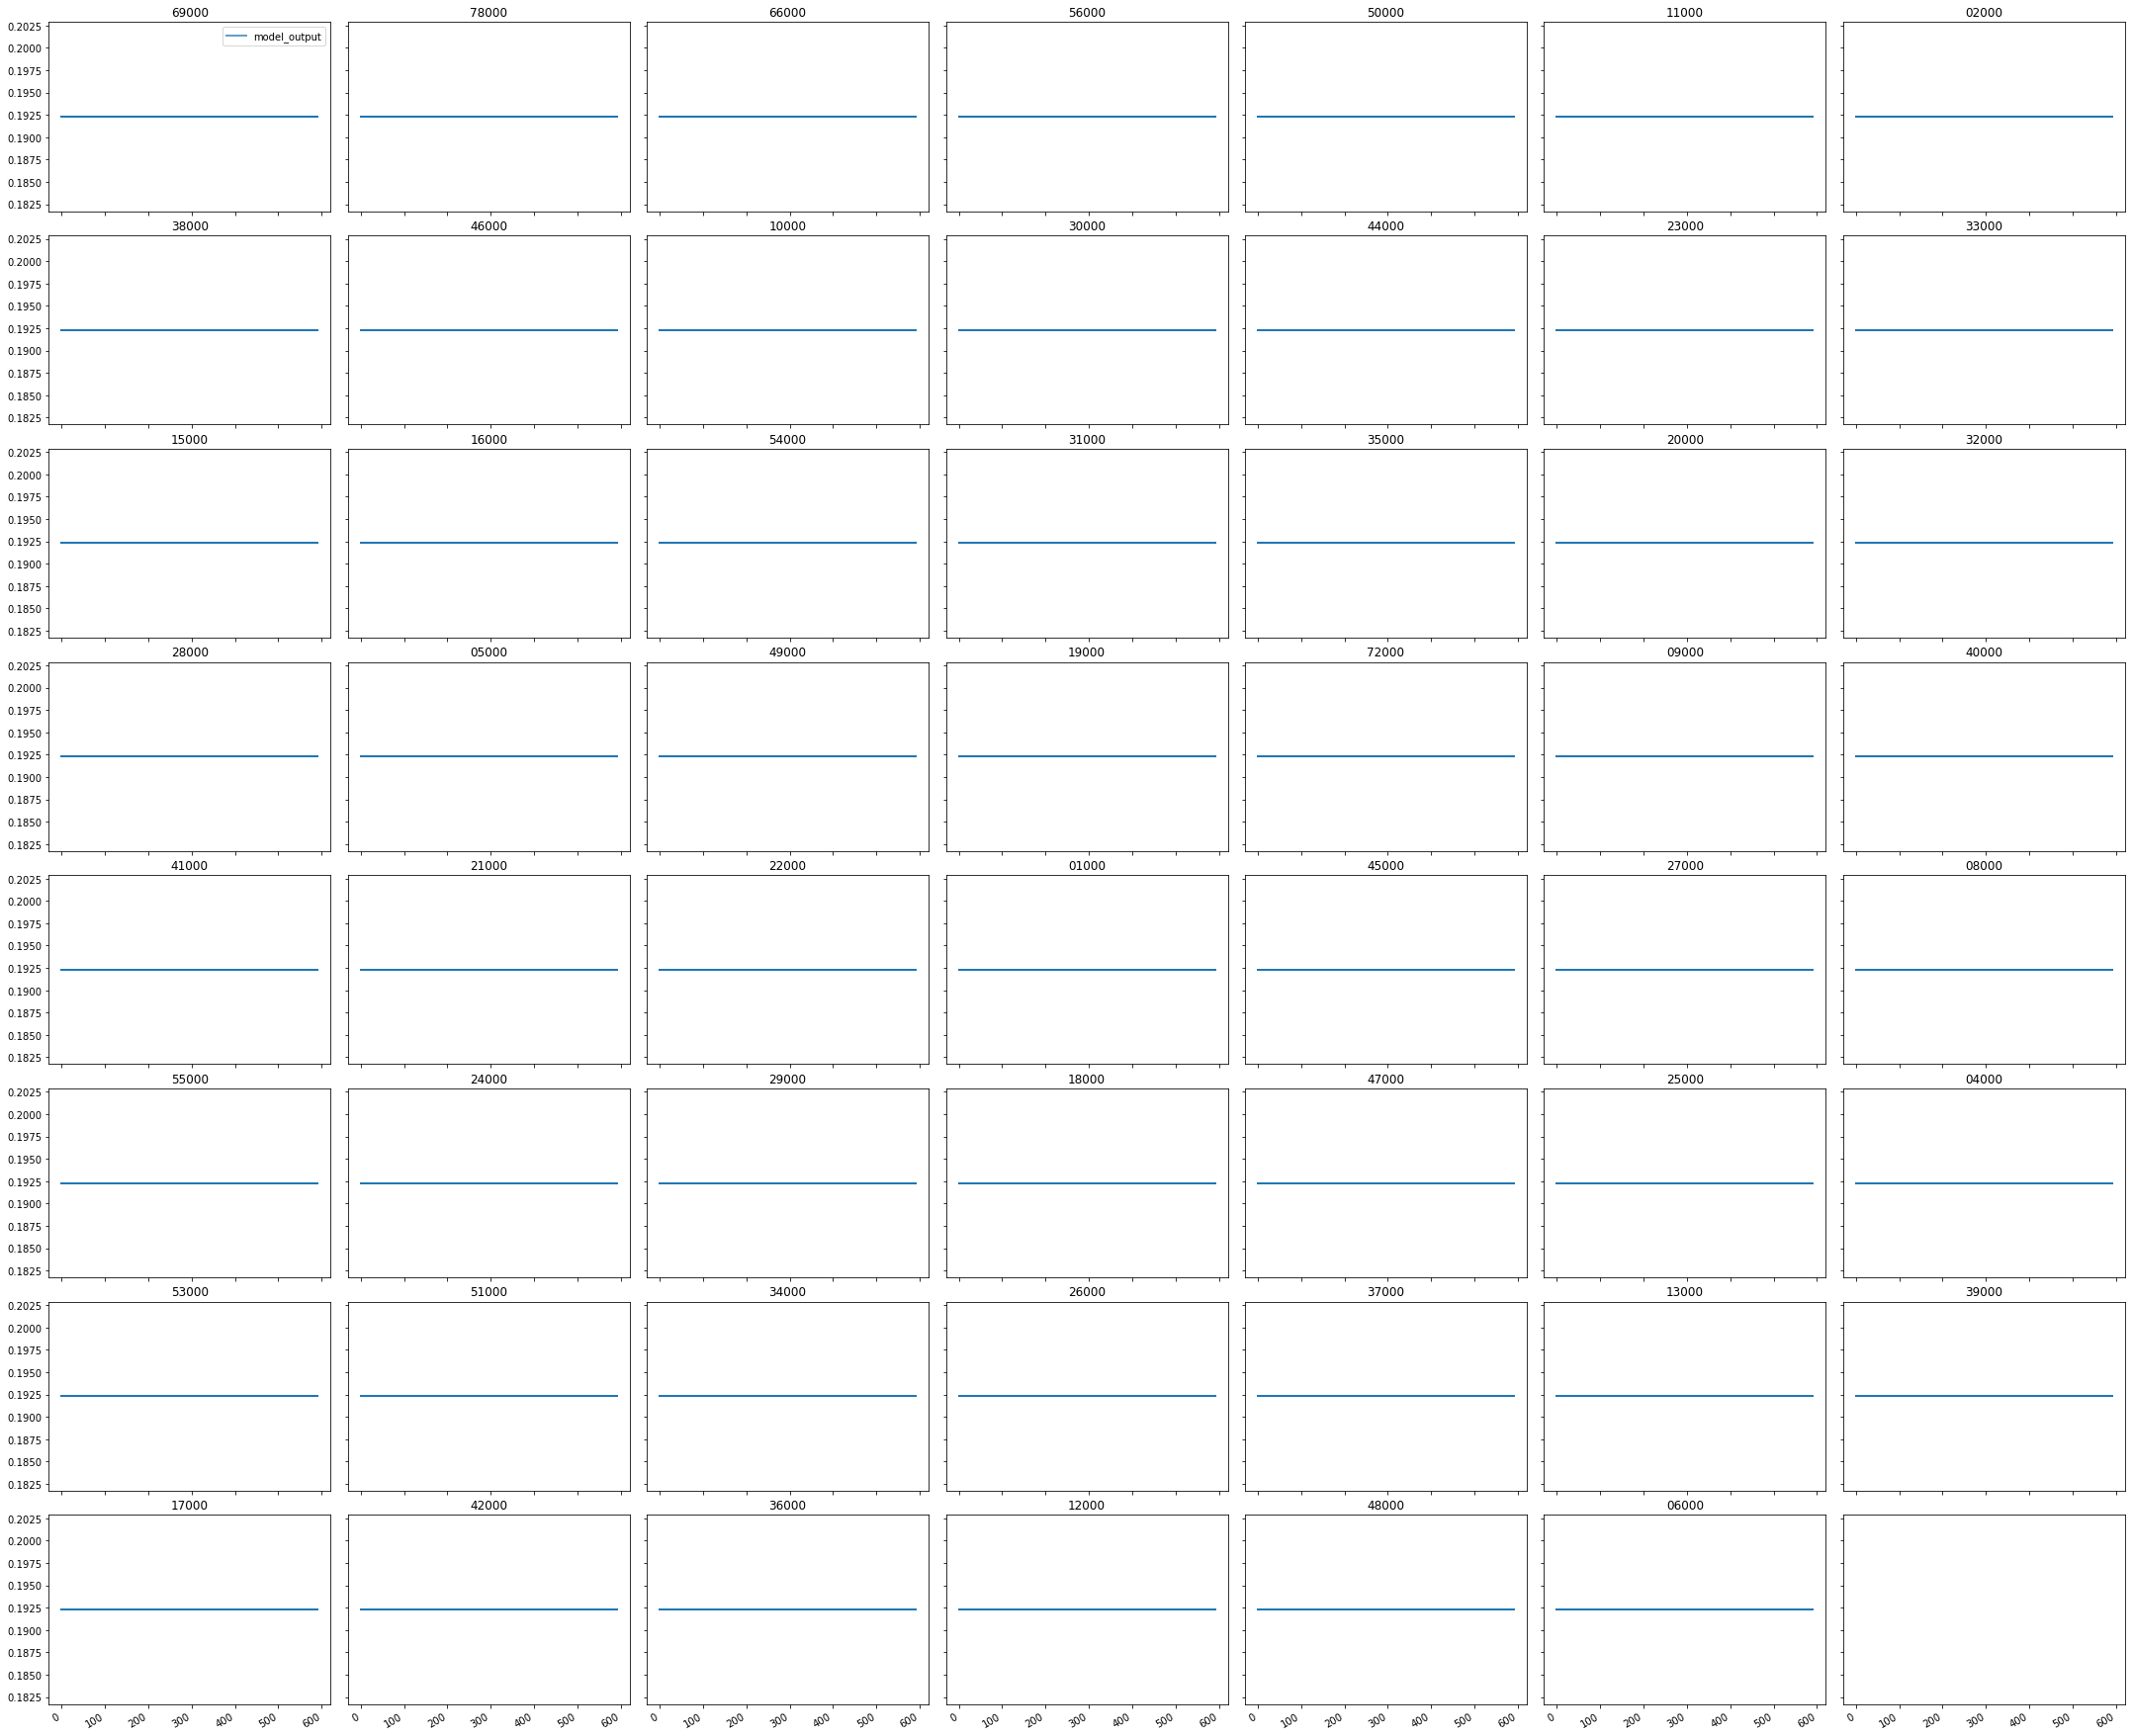

In [52]:
fig, ax = plt.subplots(8,7, figsize = (30,30), sharex = True, sharey=True)
fig.set_facecolor('white')
#colors = ['r', 'b']
j = 0

for name, dc in all_runs.items():
    k=0
    for sim, ts in enumerate(r0s[name]):
        for i, nd in enumerate(s.spatset.nodenames):
            if  k == 0:
                ax.flat[i].plot(ts.T[i], color = colors[j], alpha = .7, lw = 2, label = name)
                k = 1
            else:
                ax.flat[i].plot(ts.T[i], color = colors[j], alpha = .7, lw = 2)
            ax.flat[i].set_title(nd)
            ax.flat[i].grid()
                
    j += 1
ax.flat[0].legend()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('seir_beta.pdf')


In [53]:
ts

array([[0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769],
       [0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769],
       [0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769],
       ...,
       [0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769],
       [0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769],
       [0.19230769, 0.19230769, 0.19230769, ..., 0.19230769, 0.19230769,
        0.19230769]])